<a href="https://colab.research.google.com/github/handekaraca/WeatherPrediction/blob/main/WeatherPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("ananthr1/weather-prediction")
print("Path to dataset files:", path)

100%|██████████| 11.5k/11.5k [00:00<00:00, 15.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ananthr1/weather-prediction/versions/1


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession

# SparkSession
spark = SparkSession.builder \
    .appName("Weather Prediction Model") \
    .getOrCreate()

file_path = f"{path}/seattle-weather.csv"
weather_df = spark.read.csv(file_path, header=True, inferSchema=True)
weather_df.show()


+----------+-------------+--------+--------+----+-------+
|      date|precipitation|temp_max|temp_min|wind|weather|
+----------+-------------+--------+--------+----+-------+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain|
|2012-01-04|         20.3|    12.2|     5.6| 4.7|   rain|
|2012-01-05|          1.3|     8.9|     2.8| 6.1|   rain|
|2012-01-06|          2.5|     4.4|     2.2| 2.2|   rain|
|2012-01-07|          0.0|     7.2|     2.8| 2.3|   rain|
|2012-01-08|          0.0|    10.0|     2.8| 2.0|    sun|
|2012-01-09|          4.3|     9.4|     5.0| 3.4|   rain|
|2012-01-10|          1.0|     6.1|     0.6| 3.4|   rain|
|2012-01-11|          0.0|     6.1|    -1.1| 5.1|    sun|
|2012-01-12|          0.0|     6.1|    -1.7| 1.9|    sun|
|2012-01-13|          0.0|     5.0|    -2.8| 1.3|    sun|
|2012-01-14|          4.1|     4.4|     0.6| 5.3|   snow|
|2012-01-15|  

In [5]:
weather_df.printSchema()

selected_columns = ["date", "precipitation", "temp_max", "temp_min", "wind", "weather"]
weather_df = weather_df.select(*selected_columns)

weather_df = weather_df.na.drop()

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="weather", outputCol="label")
weather_df = indexer.fit(weather_df).transform(weather_df)

weather_df.show()

root
 |-- date: date (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- wind: double (nullable = true)
 |-- weather: string (nullable = true)

+----------+-------------+--------+--------+----+-------+-----+
|      date|precipitation|temp_max|temp_min|wind|weather|label|
+----------+-------------+--------+--------+----+-------+-----+
|2012-01-01|          0.0|    12.8|     5.0| 4.7|drizzle|  3.0|
|2012-01-02|         10.9|    10.6|     2.8| 4.5|   rain|  0.0|
|2012-01-03|          0.8|    11.7|     7.2| 2.3|   rain|  0.0|
|2012-01-04|         20.3|    12.2|     5.6| 4.7|   rain|  0.0|
|2012-01-05|          1.3|     8.9|     2.8| 6.1|   rain|  0.0|
|2012-01-06|          2.5|     4.4|     2.2| 2.2|   rain|  0.0|
|2012-01-07|          0.0|     7.2|     2.8| 2.3|   rain|  0.0|
|2012-01-08|          0.0|    10.0|     2.8| 2.0|    sun|  1.0|
|2012-01-09|          4.3|     9.4|     5.0| 3.4|   rain

In [6]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["precipitation", "temp_max", "temp_min", "wind"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

weather_df = assembler.transform(weather_df)

final_df = weather_df.select("features", "label")

final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|  [0.0,12.8,5.0,4.7]|  3.0|
| [10.9,10.6,2.8,4.5]|  0.0|
|  [0.8,11.7,7.2,2.3]|  0.0|
| [20.3,12.2,5.6,4.7]|  0.0|
|   [1.3,8.9,2.8,6.1]|  0.0|
|   [2.5,4.4,2.2,2.2]|  0.0|
|   [0.0,7.2,2.8,2.3]|  0.0|
|  [0.0,10.0,2.8,2.0]|  1.0|
|   [4.3,9.4,5.0,3.4]|  0.0|
|   [1.0,6.1,0.6,3.4]|  0.0|
|  [0.0,6.1,-1.1,5.1]|  1.0|
|  [0.0,6.1,-1.7,1.9]|  1.0|
|  [0.0,5.0,-2.8,1.3]|  1.0|
|   [4.1,4.4,0.6,5.3]|  4.0|
|  [5.3,1.1,-3.3,3.2]|  4.0|
|  [2.5,1.7,-2.8,5.0]|  4.0|
|   [8.1,3.3,0.0,5.6]|  4.0|
| [19.8,0.0,-2.8,5.0]|  4.0|
|[15.2,-1.1,-2.8,1.6]|  4.0|
| [13.5,7.2,-1.1,2.3]|  4.0|
+--------------------+-----+
only showing top 20 rows



In [7]:
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

In [10]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

lr_model = lr.fit(train_df)

print("Training is completed!")


Training is completed!


In [11]:
# Test
predictions = lr_model.transform(test_df)

predictions.select("features", "label", "prediction").show()

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


+------------------+-----+----------+
|          features|label|prediction|
+------------------+-----+----------+
|[0.0,0.0,-7.1,3.1]|  1.0|       4.0|
|[0.0,1.1,-0.6,1.9]|  3.0|       1.0|
|[0.0,2.2,-6.6,2.2]|  1.0|       4.0|
|[0.0,2.2,-4.4,1.5]|  1.0|       1.0|
|[0.0,2.8,-2.8,1.9]|  3.0|       1.0|
|[0.0,2.8,-2.1,4.7]|  1.0|       1.0|
|[0.0,3.3,-4.9,4.2]|  1.0|       4.0|
|[0.0,3.3,-1.7,0.6]|  3.0|       1.0|
|[0.0,3.3,-1.1,2.0]|  3.0|       1.0|
|[0.0,3.9,-2.8,1.0]|  3.0|       1.0|
|[0.0,4.4,-3.2,2.2]|  1.0|       1.0|
|[0.0,5.0,-2.8,1.3]|  1.0|       1.0|
|[0.0,5.0,-2.8,2.7]|  1.0|       1.0|
|[0.0,5.0,-1.6,0.8]|  1.0|       1.0|
| [0.0,5.0,0.0,2.1]|  1.0|       1.0|
| [0.0,5.0,1.7,1.7]|  2.0|       1.0|
|[0.0,5.6,-3.2,1.2]|  1.0|       1.0|
| [0.0,5.6,0.6,1.5]|  1.0|       1.0|
|[0.0,6.1,-3.9,1.8]|  3.0|       1.0|
|[0.0,6.1,-1.7,1.9]|  1.0|       1.0|
+------------------+-----+----------+
only showing top 20 rows

Model Accuracy: 82.61%


In [13]:
predictions = lr_model.transform(test_df)
predictions_pd = predictions.select("label", "prediction").toPandas()

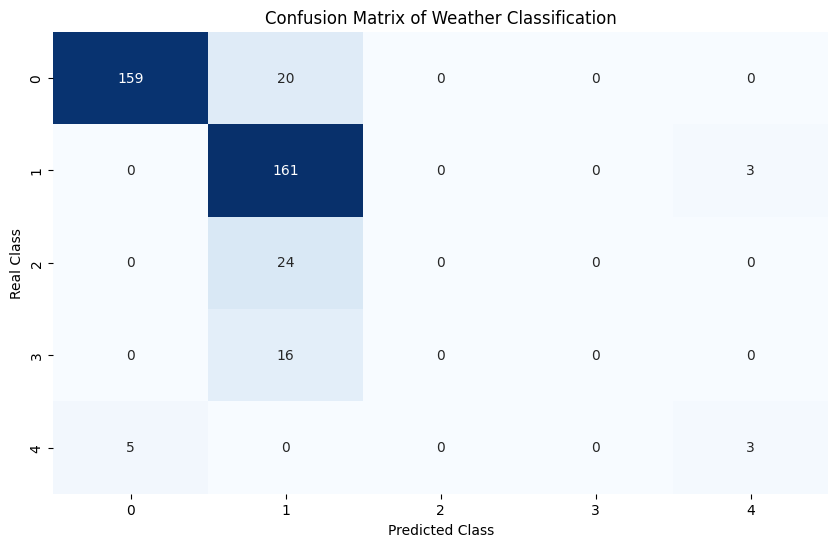

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       179
         1.0       0.73      0.98      0.84       164
         2.0       0.00      0.00      0.00        24
         3.0       0.00      0.00      0.00        16
         4.0       0.50      0.38      0.43         8

    accuracy                           0.83       391
   macro avg       0.44      0.45      0.44       391
weighted avg       0.76      0.83      0.78       391



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of Weather Classification")
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.show()

print("Classification Report:")
print(classification_report(predictions_pd['label'], predictions_pd['prediction']))


In [20]:
# Manual Test
manual_classification_data = [Row(features=Vectors.dense([1.2, 18.0, 10.0, 7.0]))]

manual_classification_df = spark.createDataFrame(manual_classification_data)
manual_classification_prediction = lr_model.transform(manual_classification_df)
manual_classification_prediction.show()


+-------------------+--------------------+--------------------+----------+
|           features|       rawPrediction|         probability|prediction|
+-------------------+--------------------+--------------------+----------+
|[1.2,18.0,10.0,7.0]|[7.52994477364794...|[0.99345545580507...|       0.0|
+-------------------+--------------------+--------------------+----------+

